# Load dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [178]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

In [179]:
from keras.layers import LSTM, Flatten

In [3]:
# Load dataset
df = pd.read_csv("datasets/ps6_trainvalid.csv")

In [181]:
df.head()

datetime  temperature  humidity  pressure       weather  \
0  2012-10-01 12:00:00          NaN       NaN       NaN           NaN   
1  2012-10-01 13:00:00   291.870000      88.0    1013.0          mist   
2  2012-10-01 14:00:00   291.868186      88.0    1013.0  sky is clear   
3  2012-10-01 15:00:00   291.862844      88.0    1013.0  sky is clear   
4  2012-10-01 16:00:00   291.857503      88.0    1013.0  sky is clear   

   wind_direction  wind_speed  
0             NaN         NaN  
1             0.0         0.0  
2             0.0         0.0  
3             0.0         0.0  
4             0.0         0.0

In [4]:
df.shape

(45013, 7)

In [56]:
df['datetime'] = pd.to_datetime(df['datetime'])
print(df.dtypes)

datetime          datetime64[ns]
temperature              float64
humidity                 float64
pressure                 float64
weather                   object
wind_direction           float64
wind_speed               float64
dtype: object


# First using only temperature to predict 'future'

## The model which can only forecast the 'next' hour

### Preprocessing

In [182]:
# Dealing with missing data
missing_data = df[pd.isnull(df["temperature"])]
missing_data.shape

(3, 7)

In [183]:
# drop those data
df = df.dropna()

In [59]:
# plot the evolution of temperature over time
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

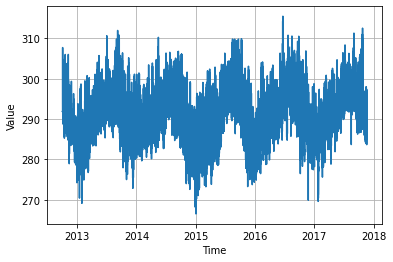

In [89]:
time = df['datetime']
temp_values = df['temperature'].values 
plot_series(time, temp_values)

In [184]:
time.shape

(44671,)

In [185]:
temp_values.shape

(44671,)

In [186]:
temp_values

array([291.87      , 291.86818552, 291.86284446, ..., 296.51      ,
       297.09      , 296.69      ])

In [5]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [64]:
n_steps = 24 * 5

X, y = split_sequence(temp_values, n_steps)

In [65]:
X.shape

(44551, 120)

In [66]:
y.shape

(44551,)

In [67]:
# Split training and validation set
n = len(X)
train_X = X[0:int(n*0.7),:]
val_X = X[int(n*0.7):,:]

train_y = y[0:int(n*0.7)]
val_y = y[int(n*0.7):]

print("Shape of training X: {}".format(train_X.shape))
print("Shape of validation X: {}".format(val_X.shape))

print("Shape of training y: {}".format(train_y.shape))
print("Shape of validation y: {}".format(val_y.shape))

Shape of training X: (31185, 120)
Shape of validation X: (13366, 120)
Shape of training y: (31185,)
Shape of validation y: (13366,)


## Linear Model

In [68]:
# define model
Linear_model = Sequential()
Linear_model.add(Dense(8, input_shape =[n_steps], activation='relu'))
Linear_model.add(Dense(1))
Linear_model.compile(loss='mse', optimizer='adam')
print(Linear_model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 8)                 968       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
# fit model
# Linear_model.fit(train_X, train_y, epochs=100, verbose=0)
Linear_model.fit(train_X, train_y, epochs=100, validation_split=0.2, verbose=2)

Epoch 1/100
780/780 - 1s - loss: 75.7868 - val_loss: 31.2741
Epoch 2/100
780/780 - 1s - loss: 27.8272 - val_loss: 17.9935
Epoch 3/100
780/780 - 1s - loss: 18.7470 - val_loss: 13.7391
Epoch 4/100
780/780 - 1s - loss: 15.9092 - val_loss: 10.0327
Epoch 5/100
780/780 - 1s - loss: 15.0621 - val_loss: 9.2044
Epoch 6/100
780/780 - 1s - loss: 14.0138 - val_loss: 19.8028
Epoch 7/100
780/780 - 1s - loss: 14.2355 - val_loss: 9.9072
Epoch 8/100
780/780 - 1s - loss: 12.0056 - val_loss: 9.6805
Epoch 9/100
780/780 - 1s - loss: 12.6859 - val_loss: 11.3424
Epoch 10/100
780/780 - 1s - loss: 10.7037 - val_loss: 6.7480
Epoch 11/100
780/780 - 1s - loss: 10.3755 - val_loss: 7.6054
Epoch 12/100
780/780 - 1s - loss: 10.3465 - val_loss: 6.2010
Epoch 13/100
780/780 - 1s - loss: 9.4626 - val_loss: 7.3828
Epoch 14/100
780/780 - 2s - loss: 8.6787 - val_loss: 13.1639
Epoch 15/100
780/780 - 1s - loss: 8.6375 - val_loss: 7.3465
Epoch 16/100
780/780 - 1s - loss: 9.5316 - val_loss: 5.6560
Epoch 17/100
780/780 - 1s - lo

In [70]:
y_true = val_y
y_true.shape

(13366,)

In [71]:
y_pred = Linear_model.predict(val_X)
y_pred.shape

(13366, 1)

In [75]:
# Evaluation
valScore = mean_squared_error(y_true, y_pred)
print('Mean Squared Error is: %.2f' % (valScore))

Mean Squared Error is: 1.73


## RNN(LSTM)

In [76]:
n_features = 1

# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [77]:
X.shape

(44551, 120, 1)

In [78]:
y.shape

(44551,)

In [79]:
# Split training and validation set
n = len(X)
train_X = X[0:int(n*0.7),:]
val_X = X[int(n*0.7):,:]

train_y = y[0:int(n*0.7)]
val_y = y[int(n*0.7):]

print("Shape of training X: {}".format(train_X.shape))
print("Shape of validation X: {}".format(val_X.shape))

print("Shape of training y: {}".format(train_y.shape))
print("Shape of validation y: {}".format(val_y.shape))

Shape of training X: (31185, 120, 1)
Shape of validation X: (13366, 120, 1)
Shape of training y: (31185,)
Shape of validation y: (13366,)


In [94]:
# Normalization
train_X_mean = train_X.mean()
train_X_std = train_X.std()

train_y_mean = train_y.mean()
train_y_std = train_y.std()

In [96]:
normalized_train_X = (train_X - train_X_mean)/train_X_std
normalized_val_X = (val_X - train_X_mean)/train_X_std

normalized_train_y = (train_y - train_y_mean)/train_y_std
normalized_val_y = (val_y - train_y_mean)/train_y_std

In [80]:
# define model
RNN_model = Sequential()
RNN_model.add(LSTM(10, activation='relu', input_shape=(n_steps, n_features)))
RNN_model.add(Dense(1))
RNN_model.compile(optimizer='adam', loss='mse')
print(RNN_model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
# fit model
RNN_model.fit(normalized_train_X, normalized_train_y, epochs=100, validation_split=0.2, verbose=2)

Epoch 1/100
780/780 - 34s - loss: 1206.0881 - val_loss: 175.5948
Epoch 2/100
780/780 - 32s - loss: 169.0961 - val_loss: 166.3976
Epoch 3/100
780/780 - 32s - loss: 159.7646 - val_loss: 157.4647
Epoch 4/100
780/780 - 35s - loss: 150.5395 - val_loss: 148.1268
Epoch 5/100
780/780 - 37s - loss: 140.9213 - val_loss: 138.0311
Epoch 6/100
780/780 - 36s - loss: 130.6278 - val_loss: 126.9684
Epoch 7/100
780/780 - 33s - loss: 119.5028 - val_loss: 114.8538
Epoch 8/100
780/780 - 35s - loss: 107.6095 - val_loss: 101.9117
Epoch 9/100
780/780 - 32s - loss: 95.2959 - val_loss: 88.6389
Epoch 10/100
780/780 - 36s - loss: 83.1238 - val_loss: 75.7276
Epoch 11/100
780/780 - 35s - loss: 71.6401 - val_loss: 63.7342
Epoch 12/100
780/780 - 36s - loss: 61.2115 - val_loss: 53.0259
Epoch 13/100
780/780 - 41s - loss: 51.9618 - val_loss: 43.6928
Epoch 14/100
780/780 - 37s - loss: 43.8313 - val_loss: 35.6734
Epoch 15/100
780/780 - 39s - loss: 36.7138 - val_loss: 28.8466
Epoch 16/100
780/780 - 36s - loss: 30.5216 - va

In [98]:
y_true = val_y
y_true.shape

(13366,)

In [99]:
normalized_y_pred = RNN_model.predict(normalized_val_X)
y_pred = normalized_y_pred * train_y.std() + train_y.mean()
y_pred.shape

(13366, 1)

In [100]:
# Evaluation
valScore = mean_squared_error(y_true, y_pred)
print('Mean Squared Error is: %.2f' % (valScore))

Mean Squared Error is: 1.03
